In [23]:
#Libraries
from matplotlib import pyplot
from numpy import savez_compressed, asarray, load
from mtcnn.mtcnn import MTCNN
from keras.models import load_model
from numpy import load
from numpy import expand_dims
from PIL import Image
from numpy import linalg as la
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from skimage.metrics import structural_similarity
from os import listdir
from os.path import isdir
import joblib
import cv2
import pickle
import numpy as np

# Load models
path_to_model = "facenet_keras.h5"
model = load_model(path_to_model) #facenet
svc_model = joblib.load('svc2.sav') #SVC

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [152]:
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
#	print(len(results))
	# extract the bounding box from each face
	faces_array = []
	for i in range(len(results)):
		x1, y1, width, height = results[i]['box']
		# bug fix
		x1, y1 = abs(x1), abs(y1)
		x2, y2 = x1 + width, y1 + height
		# extract the face
		face = pixels[y1:y2, x1:x2]
		# resize pixels to the model size
		image = Image.fromarray(face)
		image = image.resize(required_size)
		face_array = asarray(image)
		faces_array.append(face_array)
#	print(asarray(faces_array))
	return asarray(faces_array)

# get the face embedding for one face
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0] 

with open ('labels_lfw_ok.txt', 'rb') as fp:
    itemlist2 = pickle.load(fp)
with open ('labels_code_ok.txt', 'rb') as fp:
    itemlist3 = pickle.load(fp)
    
# draw an image with detected objects
def draw_image_with_boxes(filename, result_list):
	# load the image
	data = pyplot.imread(filename)
	# plot the image
	pyplot.imshow(data)
	# get the context for drawing boxes
	ax = pyplot.gca()
	# plot each box
	for result in result_list:
		# get coordinates
		x, y, width, height = result['box']
		# create the shape
		rect = Rectangle((x, y), width, height, fill=False, color='red')
		# draw the box
		ax.add_patch(rect)
#		print(result)
		# set labes
#		print(r)
#		for r in range(len(newTrainX)):
#			for t in range(len(targets)):        
#			print(t)            
#				if (newTrainX[t] != (asarray(targets[t]))).all():
#					ax.text(x, y-1, "Unknown", fontsize = 13, color = 'red')
#				else:
#					for i in range(len(itemlist3)):
#						if class_index == itemlist3[i]:
#							ax.text(x, y-1, itemlist2[i], fontsize = 13,color = 'red')

#		if result != result_list[0]:                                       

	pyplot.show()

In [155]:
# load image from file
path = 'Inferencias/tom_esposa.jpg'
filename = Image.open(path)
width, height = filename.size
if width >= 2000 and height >= 1270:
    newsize = (752, 478)
    filename = filename.resize(newsize)
    filename.save('Inferencias/resize.jpg')
    filename = 'Inferencias/resize.jpg'
    pixels = pyplot.imread(filename)
else:
    filename = path
    pixels = pyplot.imread(filename)

# create the detector, using default weights
detector = MTCNN()

# detect faces in the image
faces = detector.detect_faces(pixels)
# Extract faces in image
picture = extract_face(filename, required_size=(160, 160))
#savez_compressed('image.npz', picture)

data = load('custom_lfw_embeddings.npz')
testX = data['arr_2']
d = 14

#for i in picture:
#    pyplot.imshow(i)
#    pyplot.show()
#print(picture)

# Verify if it is a face of interest
# load faces
#data = load('custom_lfw.npz')
#testX_faces = data['arr_2']

#ssim_list = []

#for i in range(len(testX_faces)):
#    for j in range(len(picture)):
#        ssim = structural_similarity(picture[j], testX_faces[i], multichannel=True, gaussian_weights=True, full=False)
#        ssim_list.append(ssim)
#print(ssim_list)

# convert each face in the picture to an embedding

newTrainX = []

for i in range(len(picture)):
    #name = "foto" + str(i)
    #pyplot.imshow(picture[i])
    #pyplot.savefig('picture/' + name + '.jpg', bbox_inches = 'tight', pad_inches = 0)
    #pyplot.show()
    embedding = get_embedding(model, picture[i])
    newTrainX.append(embedding)

newTrainX = asarray(newTrainX)
print(newTrainX.shape)

targets = []
l2 = []
position = []

for i in range(len(newTrainX)):
    for j in range(len(testX)):
        norm = np.linalg.norm(newTrainX[i] - testX[j])
        #print(norm, i)
        #if norm <= d:
        #    targets.append(newTrainX[i])
        l2.append(norm)
        position.append(i)
        
l2 = asarray(l2)

for i in range(len(l2)):
    if l2[i] <= min(l2+1):
        targets.append(newTrainX[position[i]])

(2, 128)


This is: Tom_Hanks
Class number: 60
Class probability: 100.0


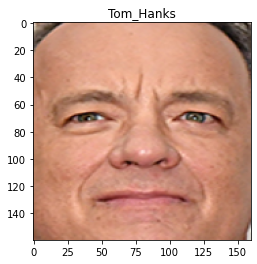

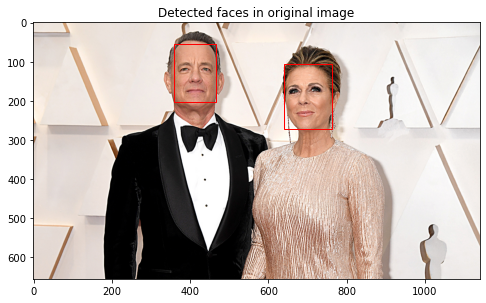

In [156]:
with open ('labels_lfw_ok.txt', 'rb') as fp:
    itemlist2 = pickle.load(fp)

with open ('labels_code_ok.txt', 'rb') as fp:
    itemlist3 = pickle.load(fp)

# prediction for the face
classes = []
class_prob = []
for i in range(len(targets)):
    face_emb = np.reshape(targets[i], (1, 128))
    #print(face_emb.shape)
    yhat_class = svc_model.predict(face_emb)
    yhat_prob = svc_model.predict_proba(face_emb)
    class_prob.append(yhat_prob)

    # get name
    class_index = yhat_class[0]
    classes.append(yhat_class)
    #print(class_index)
    class_probability = yhat_prob[0, class_index] * 100
    class_prob.append(yhat_prob)
    #print(class_probability)
    
    for l in range(len(itemlist3)):
        if class_index == itemlist3[l]:
            print('This is:' + ' ' + str(itemlist2[l]))
            title_2 = (itemlist2[l])
            
    pyplot.title(title_2)
    pyplot.imshow(picture[i])
    
    print('Class number:' + ' ' + str(class_index))
    print('Class probability:' + ' ' + str(round(class_probability, 5)))
    pyplot.show()
    
#plot for fun
f, ax = pyplot.subplots(1, 1, sharex=True, figsize=(8, 6)) 
title = ('Detected faces in original image')
pyplot.title(title)
draw_image_with_boxes(filename, faces)   

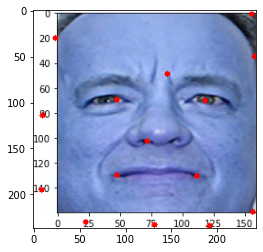

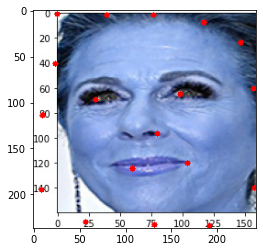

In [107]:
a = listdir('picture')
corner_list = []

for i in range(len(a)):
    path = 'picture/' + a[i]
    img = cv2.imread(path)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    corners = cv2.goodFeaturesToTrack(gray,25,0.01,45)
    corners = np.int0(corners)
    corner_list.append(corners)

    for c in corners:
        x,y = c.ravel()
        cv2.circle(img,(x,y),3,255,-1)

    pyplot.imshow(img), pyplot.show()

In [108]:
with open ('corners_lfw.txt', 'rb') as fp:
    save_corners = pickle.load(fp)

In [113]:
# Match descriptors

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary

flann = cv2.FlannBasedMatcher(index_params,search_params)
for i in range(len(corner_list)):
    for j in range(len(save_corners)):
        matches = flann.knnMatch(corner_list[i],save_corners[j],k=2)

        # Need to draw only good matches, so create a mask
        matchesMask = [[0,0] for i in range(len(matches))]

        # ratio test as per Lowe's paper
        for i,(m,n) in enumerate(matches):
            if m.distance < 0.7*n.distance:
                matchesMask[i]=[1,0]
                draw_params = dict(matchColor = (0,255,0), singlePointColor = (255,0,0), matchesMask = matchesMask, flags = cv.DrawMatchesFlags_DEFAULT)
                
        img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)
        plt.imshow(img3,),plt.show()

error: OpenCV(4.4.0) ..\modules\flann\src\miniflann.cpp:315: error: (-210:Unsupported format or combination of formats) in function 'cv::flann::buildIndex_'
> type=12
> 

In [119]:
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
for i in range(len(corner_list)):
    for j in range(len(save_corners)):
            des1 = corner_list[i]
            des2 = save_corners[j]
            # Match descriptors.
            matches = bf.match(des1,des2)
            # Sort them in the order of their distance.
            matches = sorted(matches, key = lambda x:x.distance)
            # Draw first 10 matches.
            img3 = cv2.drawMatches(img1,img2, matches[:10],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
            plt.imshow(img3),plt.show()

error: OpenCV(4.4.0) ..\modules\core\src\batch_distance.cpp:275: error: (-215:Assertion failed) type == src2.type() && src1.cols == src2.cols && (type == CV_32F || type == CV_8U) in function 'cv::batchDistance'
